In [2]:
!pip install matplotlib pandas

     |████████████████████████████████| 9.2 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 41.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 42.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 41.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 63.4 MB/s eta 0:00:01


In [2]:
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Dict, List

In [3]:
experiments_dir = Path(os.getcwd())
directories = [dir_name for dir_name in os.listdir(experiments_dir) if os.path.isdir(dir_name)]

print(directories)

['I 250000 U 125000 S 100 Y 0.4 T 3 rq 0', 'I 250000 U 125000 S 100 Y 0.2 T 3 rq 1', 'I 250000 U 125000 S 100 Y 0.6 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 500 Y 0.25 T 3 rq 1', 'I 250000 U 125000 S 2000 Y 0.25 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.8 T 3 rq 0', 'I 250000 U 125000 S 100 Y 0.1 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 1000 Y 0.25 T 3 rq 1', 'I 250000 U 125000 S 100 Y 0.2 T 3 rq 0', 'I 250000 U 125000 S 10 Y 0.25 T 3 rq 0', 'I 250000 U 125000 S 1000 Y 0.25 T 3 rq 0', 'I 250000 U 125000 S 500 Y 0.25 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 100 Y 0.25 T 3 rq 0', 'I 250000 U 125000 S 100 Y 0.1 T 3 rq 0', 'I 250000 U 125000 S 10 Y 0.25 T 3 utl 0.4 ltu 0.8 rq 1', 'I 250000 U 125000 S 10 Y 0.25 T 3 rq 1', 'I 250000 U 125000 S 100 Y 0.8 T 3 rq 1', 'I 250000 U 125000 S 100 Y 0.6 T 3 rq 1', 'I 250000 U 125000 S 100 Y 0.6 T 3 rq 0', 'I 250000 U 125000 S 100 Y 0.4 T 3 rq 1', 'I 250000 U

In [4]:
def process_text_stats(stats_file) -> Dict[str, int]:
    stats_to_pull = [
        "rocksdb.compaction.key.drop.new",
        "rocksdb.number.db.seek",
        "rocksdb.number.db.next",
        "rocksdb.number.db.seek.found",
        "rocksdb.number.db.next.found",
        "rocksdb.db.iter.bytes.read",
        "rocksdb.no.file.opens",
        "rocksdb.compact.read.bytes",
        "rocksdb.compact.write.bytes",
        "rocksdb.flush.write.bytes",
        "rocksdb.read.amp.estimate.useful.bytes",
        "rocksdb.read.amp.total.read.bytes",
        "rocksdb.files.deleted.immediately",
        "rocksdb.memtable.payload.bytes.at.flush",
        "rocksdb.compaction.times.micros",
        "rocksdb.read.block.compaction.micros",
        "rocksdb.write.raw.block.micros",
        "rocksdb.numfiles.in.singlecompaction",
        "rocksdb.file.read.compaction.micros",
        "rocksdb.db.flush.micros",
    ]

    filtered_dictionary = dict()
    with open(stats_file, "r") as file:
        for line in file:
            found_stat = False
            for stat in stats_to_pull:
                if line.startswith(stat):
                    line = line.strip(" \n ")
                    parts = line.split(":")
                    if len(parts) == 2:
                        filtered_dictionary[stat] = parts[1].strip()
                        found_stat = True
                    else:
                        for index, part in enumerate(parts):
                            if "COUNT" in part:
                                filtered_dictionary[stat] = (
                                    parts[index + 1].strip().split(" ")[0].strip()
                                )
                                found_stat = True
                                break

                if found_stat:
                    break

    return filtered_dictionary

In [5]:
results = pd.DataFrame(
    columns=[
        'workload',
        'inserts', 
        'updates', 
        'deletes', 
        'rangeQueries', 
        'selectivity', 
        'sizeRatio', 
        'writeCost', 
        'upperToLowerRatio', 
        'lowerToUpperRatio', 
        'approach',
        'bytesWrittenInCompaction',
        'bytesWrittenInBufferWrites',
        'bytesWrittenInTotal',
        'writeAmp',
    ]
)

skipped_vs_compacted = dict()

for directory in directories:
    directory_path = experiments_dir / directory
    _, inserts, _, updates, _, range_queries, _, selectivity, _, size_ratio, *args = directory.split(' ')
    approach = int(args.pop(-1))
    args.pop(-1)

    upper_to_lower_ratio = float(args.pop(1)) if len(args) > 0 else 0
    args.pop(0) if len(args) > 0 else None
    lower_to_upper_ratio = float(args.pop(1)) if len(args) > 0 else float('inf')
    args.pop(0) if len(args) > 0 else None
    write_cost = float(args.pop(1)) if len(args) > 0 else 0
    args.pop(0) if len(args) > 0 else None
    
    result_row = {
        'workload': directory,
        'inserts': int(inserts),
        'updates': int(updates),
        'deletes': 0,
        'rangeQueries': int(range_queries),
        'selectivity': float(selectivity),
        'sizeRatio': int(size_ratio),
        'writeCost': write_cost,
        'upperToLowerRatio': upper_to_lower_ratio,
        'lowerToUpperRatio': lower_to_upper_ratio,
        'approach': 'rqdc' if approach == 1 else 'vanilla',
        'bytesWrittenInCompaction': 0,
        'bytesWrittenInBufferWrites': 0,
        'bytesWrittenInTotal': 0,
        'writeAmp': 0,
    }

    for file in os.listdir(directory_path):
        if file.endswith('stats.txt'):
            file_path = directory_path / file
            stats = process_text_stats(file_path)
            result_row['bytesWrittenInCompaction'] = int(stats['rocksdb.compact.write.bytes'])
            result_row['bytesWrittenInBufferWrites'] = int(stats['rocksdb.flush.write.bytes'])
            result_row['bytesWrittenInTotal'] = int(stats['rocksdb.compact.write.bytes']) + int(stats['rocksdb.flush.write.bytes'])
            result_row['writeAmp'] = float(result_row['bytesWrittenInTotal'] / result_row['inserts'] * 1024)
            results = results.append(result_row, ignore_index=True)
            # print(result_row)
        if file.endswith('compacted_vs_skipped.csv'):
            file_path = directory_path / file
            data = pd.read_csv(file_path)
            data['Skipped_Count'] = (data['Compacted'] == 0).astype(int)
            skipped_vs_compacted[directory] = data

In [6]:
results.head()

,workload,inserts,updates,deletes,rangeQueries,selectivity,sizeRatio,writeCost,upperToLowerRatio,lowerToUpperRatio,approach,bytesWrittenInCompaction,bytesWrittenInBufferWrites,bytesWrittenInTotal,writeAmp
0,I 250000 U 125000 S 100 Y 0.4 T 3 rq 0,250000,125000,0,100,0.40,3,0,0,inf,vanilla,3059462255,389753751,3449216006,1.412799e+07
1,I 250000 U 125000 S 100 Y 0.2 T 3 rq 1,250000,125000,0,100,0.20,3,0,0,inf,rqdc,1748206199,3061930499,4810136698,1.970232e+07
2,I 250000 U 125000 S 100 Y 0.6 T 3 utl 0.4 ltu ...,250000,125000,0,100,0.60,3,0,0.4,0.8,rqdc,2225240949,1594566133,3819807082,1.564593e+07
3,I 250000 U 125000 S 100 Y 0.25 T 3 utl 0.4 ltu...,250000,125000,0,100,0.25,3,0,0.4,0.8,rqdc,2361156489,1336497156,3697653645,1.514559e+07
4,I 250000 U 125000 S 500 Y 0.25 T 3 rq 1,250000,125000,0,500,0.25,3,0,0,inf,rqdc,1123014961,12736860674,13859875635,5.677005e+07


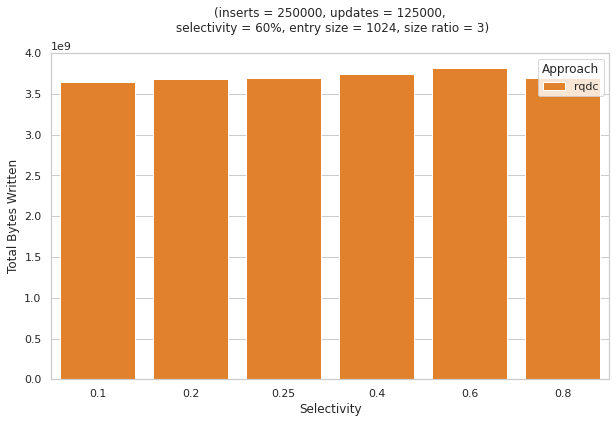

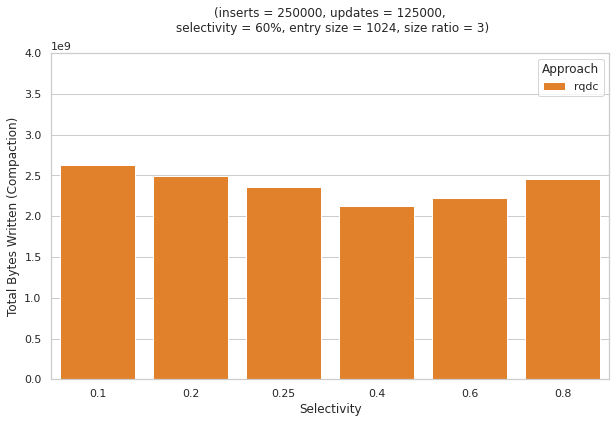

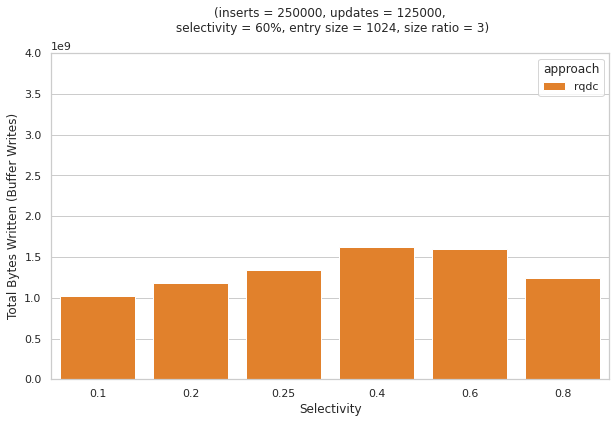

In [35]:
# size_ratios = [2, 3, 4, 5, 8, 10, 16]

# filters to apply on dataframe (column name: [values])
# filters = {
#     "rangeQueries": [10],
#     "selectivity": [0.1, 0.2, 0.4, 0.6, 0.8],
# }

size_ratios = [3]

custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for i, size_ratio in enumerate(size_ratios):
    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]

    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['rangeQueries'] == 100]
    # size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['selectivity'] == 0.25]
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['approach'] == 'rqdc']
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['upperToLowerRatio'] == 0.4]

    # size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['updates'] == updates[i]]
    df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'upperToLowerRatio', 'approach', 'bytesWrittenInTotal']]

    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # vanilla = df[df['approach'] == 'vanilla']
    rqdc = df[df['approach'] == 'rqdc']
    # plt.axhline(y=vanilla['bytesWrittenInTotal'].iloc[0], color='#1f77b4', linestyle='--', label='vanilla')
    ax = sns.barplot(x="selectivity", y="bytesWrittenInTotal", hue="approach", data=rqdc, palette=custom_colors)
    ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]},\n selectivity = {int(df['selectivity'].iloc[0]*100)}%, entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    ax.set(xlabel='Selectivity', ylabel='Total Bytes Written')
    # ax.set(xlabel='Number of Range Queries', ylabel='Total Bytes Written')

    max_y = 4000000000
    ax.set(ylim=(0, max_y))
    ax.legend(title="Approach", loc="upper right")
    plt.show()


# # # size_ratios = [2, 3, 4, 5, 8, 10, 16]
# # # custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for i, size_ratio in enumerate(size_ratios):
    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['rangeQueries'] == 100]
    # size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['selectivity'] == 0.25]
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['approach'] == 'rqdc']
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['upperToLowerRatio'] == 0.4]


    df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'upperToLowerRatio', 'approach', 'bytesWrittenInCompaction']]

    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # vanilla = df[df['approach'] == 'vanilla']
    rqdc = df[df['approach'] == 'rqdc']
    # plt.axhline(y=vanilla['bytesWrittenInTotal'].iloc[0], color='#1f77b4', linestyle='--', label='vanilla')
    ax = sns.barplot(x="selectivity", y="bytesWrittenInCompaction", hue="approach", data=rqdc, palette=custom_colors)
    ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]},\n selectivity = {int(df['selectivity'].iloc[0]*100)}%, entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    ax.set(xlabel='Selectivity', ylabel='Total Bytes Written (Compaction)')
    # ax.set(xlabel='Number of Range Queries', ylabel='Total Bytes Written (Compaction)')



    # df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'upperToLowerRatio', 'approach', 'bytesWrittenInCompaction']]
    # df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    # sns.set_theme(style="whitegrid")
    # plt.figure(figsize=(10, 6))
    # # vanilla = df[df['approach'] == 'vanilla']
    # rqdc = df[df['approach'] == 'rqdc']
    # # plt.axhline(y=vanilla['bytesWrittenInCompaction'].iloc[0], color='#1f77b4', linestyle='--', label='vanilla')
    # ax = sns.barplot(x="selectivity", y="bytesWrittenInCompaction", hue="approach", data=rqdc, palette=custom_colors)
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n selectivity = {int(df['selectivity'].iloc[0]*100)}%, entry size = 1024, size ratio = {size_ratio})\n")
    # ax.set(xlabel='Number of useful entries threshold between adjacent levels', ylabel='Total Bytes Written (Compaction)')

    max_y = 4000000000
    ax.set(ylim=(0, max_y))
    ax.legend(title="Approach", loc="upper right")
    plt.show()

# # # size_ratios = [2, 3, 4, 5, 8, 10, 16]
# # # custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

for i, size_ratio in enumerate(size_ratios):

    size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['rangeQueries'] == 100]
    # size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['selectivity'] == 0.25]
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['approach'] == 'rqdc']
    size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['upperToLowerRatio'] == 0.4]


    df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'upperToLowerRatio', 'approach', 'bytesWrittenInBufferWrites']]

    df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    # vanilla = df[df['approach'] == 'vanilla']
    rqdc = df[df['approach'] == 'rqdc']
    # plt.axhline(y=vanilla['bytesWrittenInTotal'].iloc[0], color='#1f77b4', linestyle='--', label='vanilla')
    ax = sns.barplot(x="selectivity", y="bytesWrittenInBufferWrites", hue="approach", data=rqdc, palette=custom_colors)
    ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]},\n selectivity = {int(df['selectivity'].iloc[0]*100)}%, entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    # ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n entry size = 1024, size ratio = {size_ratio})\n")
    ax.set(xlabel='Selectivity', ylabel='Total Bytes Written (Buffer Writes)')
    # ax.set(xlabel='Number of Range Queries', ylabel='Total Bytes Written (Buffer Writes)')


#     size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
#     size_ratio_2_vs_write_cost_25_percent = size_ratio_2_vs_write_cost_25_percent[size_ratio_2_vs_write_cost_25_percent['updates'] == updates[i]]
#     df = size_ratio_2_vs_write_cost_25_percent[['inserts', 'updates', 'rangeQueries', 'selectivity', 'writeCost', 'upperToLowerRatio', 'approach', 'bytesWrittenInBufferWrites']]
#     df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

#     sns.set_theme(style="whitegrid")
#     plt.figure(figsize=(10, 6))
#     vanilla = df[df['approach'] == 'vanilla']
#     rqdc = df[df['approach'] == 'rqdc']
#     plt.axhline(y=vanilla['bytesWrittenInBufferWrites'].iloc[0], color='#1f77b4', linestyle='--', label='vanilla')
#     ax = sns.barplot(x="upperToLowerRatio", y="bytesWrittenInBufferWrites", hue="approach", data=rqdc, palette=custom_colors)
#     ax.title.set_text(f"(inserts = {df['inserts'].iloc[0]}, updates = {df['updates'].iloc[0]}, range queries = {df['rangeQueries'].iloc[0]},\n selectivity = {int(df['selectivity'].iloc[0]*100)}%, entry size = 1024, size ratio = {size_ratio})\n")
#     ax.set(xlabel='Number of useful entries threshold between adjacent levels', ylabel='Total Bytes Written (Buffer Writes)')

    max_y = 4000000000
    ax.set(ylim=(0, max_y))
    # ax.legend(title="Approach", loc="upper right")
    plt.show()

# size_ratios = [2, 3, 4, 5, 8, 10, 16]
# custom_colors = {"vanilla": "#1f77b4", "rqdc": "#ff7f0e"}

# for size_ratio in size_ratios:
#     size_ratio_2_vs_write_cost_25_percent = results[results['sizeRatio'] == size_ratio]
#     df = size_ratio_2_vs_write_cost_25_percent[['writeCost', 'approach', 'writeAmp']]
#     df = df.sort_values(by=['writeCost', 'approach'], ascending=False)

#     sns.set_theme(style="whitegrid")
#     ax = sns.lineplot(x="writeCost", y="writeAmp", hue="approach", data=df, palette=custom_colors)
#     ax.title.set_text(f"Size Ratio: {size_ratio}")
#     ax.set(xlabel='Write Cost (%)', ylabel='Total Bytes Written (Buffer Writes)')

#     # Uncomment the following lines if you want to set a specific y-axis limit:
#     # max_y = 6000000000
#     # ax.set(ylim=(0, max_y))

#     ax.legend(title="Approach", loc="upper right")
#     plt.show()

In [20]:
skipped_vs_compacted

{'I 250000 U 125000 S 100 Y 0.25 T 3 utl 0.4 ltu 0.8 rq 1':     Range Query No.  Compacted  Skipped  Skipped_Count
 0                 1       5698      111              0
 1                 2          0      219              1
 2                 3          0      440              1
 3                 4          0      578              1
 4                 5       2027      809              0
 ..              ...        ...      ...            ...
 95               96       4054     4034              0
 96               97      14189     4393              0
 97               98          0     4908              1
 98               99       2027     4991              0
 99              100          0     6214              1
 
 [100 rows x 4 columns],
 'I 250000 U 125000 S 100 Y 0.25 T 3 rq 0':     Range Query No.  Compacted  Skipped  Skipped_Count
 0                 1          0      151              1
 1                 2          0      104              1
 2                 3          0

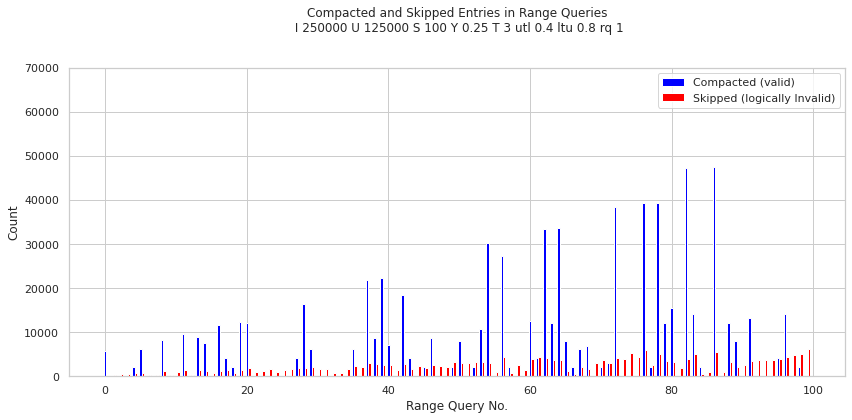

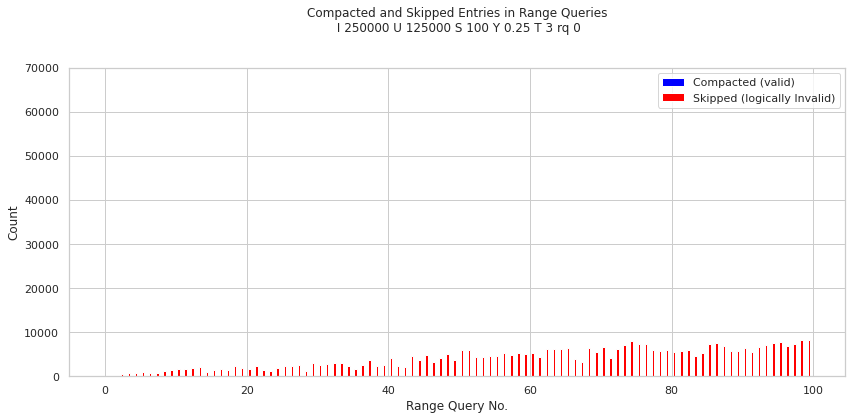

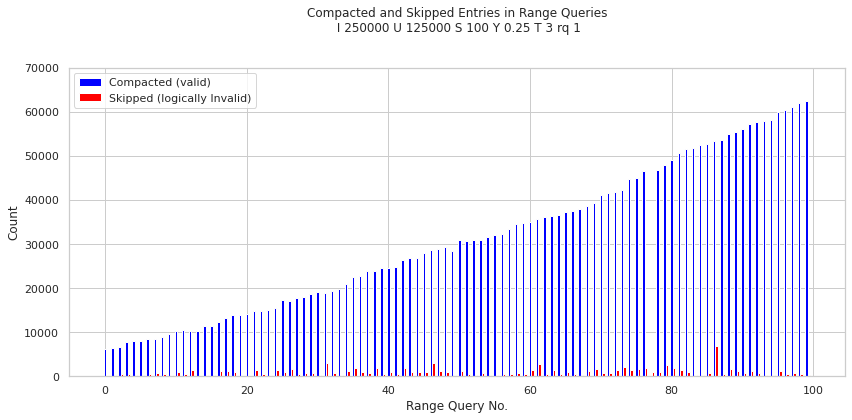

In [21]:
import numpy as np


for directory in directories:
    data = skipped_vs_compacted[directory]

    # filtered_data = data[data['Compacted'] > 0]

    query_data = []

    for index, row in data.iterrows():
        range_query_no = row['Range Query No.']
        compacted_count = row['Compacted']
        skipped_count = row['Skipped']

        query_data.append((range_query_no, compacted_count, skipped_count))

    # Sort the data by range query number
    query_data.sort(key=lambda x: x[0])

    # Extract data for plotting
    range_queries = [x[0] for x in query_data]
    compacted_entries = [x[1] for x in query_data]
    skipped_entries = [x[2] for x in query_data]

    # Create a bar plot with two bars for each range query
    bar_width = 0.35
    index = np.arange(len(range_queries))

    plt.figure(figsize=(12, 6))
    plt.bar(index, compacted_entries, bar_width, label='Compacted (valid)', color='blue')
    plt.bar(index + bar_width, skipped_entries, bar_width, label='Skipped (logically Invalid)', color='red')

    max_y = 70000
    plt.ylim(0, max_y)
    plt.xlabel('Range Query No.')
    plt.ylabel('Count')
    plt.title(f'Compacted and Skipped Entries in Range Queries\n {directory}\n\n')

    # Rotate x-axis labels (ticks) to a custom angle (e.g., 90 degrees for vertical labels)
    # plt.xticks(index + bar_width / 2, range_queries, rotation=90, ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()